## Purpose

The goal of this tutorial is to reduce the size of an IFC file. Indeed, IFC files can become rather large and processing them can lead to expensive computational costs. Most of the time, this important size is due to duplicate entity instances. In this tutorial, we're going to see how to create a newly optimized file which doesn't contain those instances.<!-- TEASER_END -->

## Download resources from the web

### Download ifcopenshell-python

In [4]:
import urllib.request
url = 'https://s3.amazonaws.com/ifcopenshell-builds/ifcopenshell-python-36-v0.6.0-0d93633-linux64.zip'
filename = 'ifcopenshell.zip'
urllib.request.urlretrieve(url, filename)

('ifcopenshell.zip', <http.client.HTTPMessage at 0x20a4cbbf8c8>)

In [5]:
import zipfile
with zipfile.ZipFile('ifcopenshell.zip', 'r') as zip_ref:
    zip_ref.extractall('ifcopenshell')

In [12]:
!pip install toposort
from toposort import toposort_flatten as toposort

The system cannot find the path specified.


### Download an IFC file

In [6]:
import urllib.request
url = 'http://openifcmodel.cs.auckland.ac.nz/_models/030811DuplexModel-IFC-2011-05-05.zip'
filename = 'Duplex_files.zip'
urllib.request.urlretrieve(url, filename)

('Duplex_files.zip', <http.client.HTTPMessage at 0x20a4d102848>)

In [7]:
import zipfile
with zipfile.ZipFile('Duplex_files.zip', 'r') as zip_ref:
    zip_ref.extractall('Duplex')

## Visualize the number of occurences for single a non-optimized IFC file

In [1]:
import ifcopenshell

file = ifcopenshell.open('Duplex/Duplex_A_20110505.ifc')

### Extract the IFC entity types frequency

In [2]:
types = set(i.is_a() for i in file)
types_count = {t:len(file.by_type(t)) for t in types}

In [3]:
occurences = sorted(types_count.items(), key = lambda kv:kv[1], reverse = True)

In [4]:
occurences = [occurence for occurence in occurences if occurence[1] > 400]

### Plot the frequency

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import operator

In [6]:
x_values = [val[0] for val in occurences]
y_values = [val[1] for val in occurences]

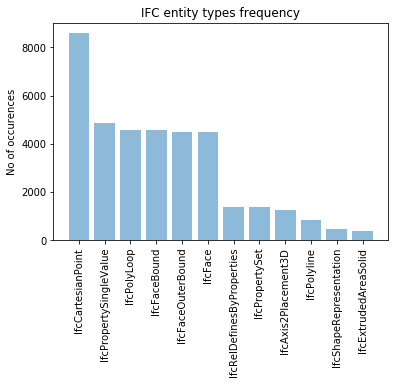

In [10]:
objects = x_values
y_pos = np.arange(len(objects))
performance = y_values

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects, rotation=90, size=10)


plt.ylabel('No of occurences')
plt.title('IFC entity types frequency')

plt.show()

It could be more convenient to write the above code to a function. We use a `n_types` parameter to control how many entities we want to see plotted. 

In [18]:
def plot_multiple(files, n_types):
    """
    This function enables to plot
    the frequency of a defined number of the most populated entity types.
    """
    
    count = 0
    res = []
    ordered_types = []
    
    for file in files: 
        file = ifcopenshell.open(file)
        types = set(i.is_a() for i in file)
        types_count = {t:len(file.by_type(t)) for t in types}
        res.append(types_count)
        occurences = sorted(types_count.items(), key = lambda kv:kv[1], reverse = True)
        occurences = occurences[0:n_types]


        if count == 0: 
            for occurence in occurences:
                ordered_types.append(occurence[0])
        
        count += 1
        

    result_container = []

    for r in res:
        container = []
        for t in ordered_types:
            container.append(r[t])

        result_container.append(container)
    
    

    X = ordered_types
        

    def subcategorybar(X, vals, width=0.8):
        n = len(vals)
        _X = np.arange(len(X))
        for i in range(n):
            plt.bar(_X - width/2. + i/float(n)*width, vals[i], width=width/float(n), align="center", label=files[i])
            
        plt.xticks(_X, X, rotation=90)
        plt.legend(framealpha=1, frameon=True);

    subcategorybar(X, result_container)


    plt.show()
    
    


## Let's optimize this file

### Topological sort

Topological sort enables to sort a graph regarding to the dependency of its nodes. More precisely, it means that the nodes with no or the highest parents in the graph hierachy will be the first ones of the sorted list.

Thus, there are several possible topological sorts of the same graph since some nodes can be siblings, and thus it still respect the idea of the sort because they hold the same hierarchical position (or degree) within the graph.

For an IFC file, in which entity instances are literally defined line by line with nodes refering to other ones, it is a good solution to keep the "less dependent" entities sorted to eliminate the duplicate ones. Therefore, the most independent entities are sorted the first and the next instances can refer to them.

```
#1=IFCCARTESIANPOINT((0.0, 0.0, 0.0));
#2=IFCCARTESIANPOINT((1.0, 0.0, 0.0));
#3=IFCCARTESIANPOINT((0.0, 0.0, 0.0));
#4=IFCPOLYLINE((#1, #2, #3));
```

In the example above, what would be written to the new file is `IFCPOLYLINE((#1, #2, #1));` and `#3` won't be added. Numeric identifiers will be changed though and will increment from 1 based on insertion order (so based on the topological sort).

Below is a general example of a topological sort from https://en.wikipedia.org/wiki/Topological_sorting.

![image.png](/images/toposort.png)

In [12]:
import ifcopenshell
from toposort import toposort_flatten as toposort

f = ifcopenshell.open('Duplex/Duplex_A_20110505.ifc')
g = ifcopenshell.file(schema=f.schema)

We create a generator which will go through all the relations of each instance of the IFC file. 

In [29]:
def generate_instances_and_references():
    """
    Generator which yields an entity id and 
    the set of all of its references contained in its attributes. 
    """
    for inst in f:
        yield inst.id(), set(i.id() for i in f.traverse(inst)[1:] if i.id())

        
instance_mapping = {}

The `map_value` function enables to recursively traverse the values of the attributes of an entity instance. It takes as input an attribute of an IFC instance. If the attribute is a list or a tuple, then it will recursively calls itself. If the attribute is python value, then it will output this value.
The interesting part happens when the attribute references another IFC instance. First, it could be an IFC instance which is the equivalent of a primitive python type, like IfcBoolean, or IfcInteger. In that case, this is return by recreating the entity and its value stored at index 0. 
In other cases, when the attribute is an IFC instance, `map_value` is going to create the attribute. But is it created by taking its value in the `instance_mapping` mapping variable. Since the entities have been sorted with the toposort, it is sure that the reference has already been registered. Otherwise, if there were no toposort, the entity would not be registered for sure and this could an error. 

In [33]:
def map_value(v):
    """
    Recursive function which replicates an entity instance, with 
    its attributes, mapping references to already registered
    instances. Indeed, because of the toposort we know that 
    forward attribute value instances are mapped before the instances
    that reference them.
    """
    if isinstance(v, (list, tuple)):
        # lists are recursively traversed
        return type(v)(map(map_value, v))
    elif isinstance(v, ifcopenshell.entity_instance):
        if v.id() == 0:
            # express simple types are not part of the toposort and just copied
            return g.create_entity(v.is_a(), v[0])
  
        
        return instance_mapping[v]
    else:
        # a plain python value can just be returned
        return v

In the code below, we loop through each entity instance ID, output by the generator we wrote above, and we take a sorted  version of this output. As describe earlier, we use the topological sort to sort the IFC instance regarding to their references. The instances with less references will be ranked first. For each entity instance, we take the information of this entity with the `get_info` method. This will return a frozenset, an immutable data structure. 

If it's the first time we encounter the instance, thanks to this immutable property, we can create a key value pair in the dictionary `info_to_id` for which the key is the information anf the value is the ID. This means we have registered the entity instance. In addition, and this is the core of the algorithm, we add this entity instance to a new file `g`. We do this addition with the `map_value function` we already described. 

The fact that we take the information of an instance as a frozenset helps us test its membership. In addition, ff an entity has already been visited, so if its information is in the set of the `info_to_id` dictionary keys, then `instance_mapping` will basically map the current instance to the one it has already encountered. It means that the new instance is not added and there will be no reference to it with a new id.



In [15]:
info_to_id = {}
    
    
for id in toposort(dict(generate_instances_and_references())):
    inst = f[id]
    info = inst.get_info(include_identifier=False, recursive=True, return_type=frozenset)
    if info in info_to_id:
        mapped = instance_mapping[inst] = instance_mapping[f[info_to_id[info]]]

    else:
        info_to_id[info] = id
        instance_mapping[inst] = g.create_entity(
            inst.is_a(),
            *map(map_value, inst)
        )
g.write("Duplex_optimized.ifc")

To illustrate the code on a trivial example, consider a mini IFC file made of these instances: 

```
#1=IFCCARTESIANPOINT((0.0, 0.0, 0.0));
#2=IFCCARTESIANPOINT((1.0, 0.0, 0.0));
#3=IFCCARTESIANPOINT((0.0, 0.0, 0.0));
#4=IFCPOLYLINE((#1, #2, #3));
```

For this simple example, let's call the instances by their id. First, `#1` will be stored and added to the new file. Same for `#2`. When `#3` comes up, it will be mapped to the similar instance already registed, so `#1`. At `#4`, the `map_value` function will use `#3` as the key in instance mapping, which is mapped to `#1`, so `#1` will be added to the new file and not `#3`. 

#### Small examples of `map_value` return values

In [8]:
w = f.by_type("IfcWall")[5]

In [9]:
map_value(w)

#50701=IfcWallStandardCase('2O2Fr$t4X7Zf8NOew3FKGS',#39370,'Basic Wall:Interior - Partition (92mm Stud):139939',$,'Basic Wall:Interior - Partition (92mm Stud):128360',#50370,#50371,'139939')

In [21]:
map_value({'abc',7, w})

{#4553=IfcWallStandardCase('2O2Fr$t4X7Zf8NOew3FKGS',#33,'Basic Wall:Interior - Partition (92mm Stud):139939',$,'Basic Wall:Interior - Partition (92mm Stud):128360',#4540,#4552,'139939'),
 7,
 'abc'}

### Write newly created IFC file and compare to the original one

In [58]:
g.write("Duplex_optimized.ifc")

We can plot the newly created file to check the improvement. 

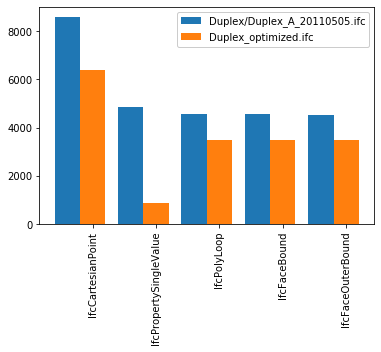

In [16]:
plot_multiple(['Duplex/Duplex_A_20110505.ifc','Duplex_optimized.ifc'], 5)

If we compare it to the previous graph, we can see, for example, a reduction of about 2000 `IfcCartesianPoint` instances, which serves well our purpose of optimizing the file size. More globally, the file size has gone from 2311 KB to 1558 KB, which represents a reduction of 32%.  

### Plot for multiple files and compare

We can now use the code of the `plot_types_frequency` we wrote before to create a `plot_multiple` function which will serve the same purpose but for an unlimited number of file. Thanks to this function, will be able to see the differences between the original file and the one we optimized. In addition, we have optimized a file with the Solibri Optimizer and we'll add the results of this file as well.

In [61]:
import ifcopenshell

import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import numpy as np

files = ['Duplex/Duplex_A_20110505.ifc', 'Duplex_optimized.ifc', 'Duplex_solibri.ifc']


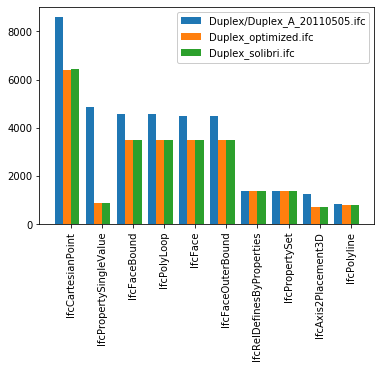

In [63]:
plot_multiple(files,10)

As shown above, our method performs a bit better or equally than the Solibri Optimizer https://www.solibri.com/solibri-ifc-optimizer on this file. 

Below is a visualization of the Duplex file displayed in the PyraBIM https://pyrabim.com/en/index.html viewer, in which we incorporated the same graph. 

![image.png](/images/pyrabim_stats.png)